# Analyze E-commerce A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction
 
We get data about users who enroll/visit a course page. Our goal is to come up with recommendations for the product and the marketing teams to implement the changes or not. We have a new UI change and we want to investigate whether to launch the change given the data below. Below is an overview of the dataset.


<a id='probability'></a>
#### Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import stats

%matplotlib inline
random.seed(42)
#helps control randomness, increases experiment reproducibility and comparability, and allows result replication

`1.` read in the `ab_data.csv` data. Store it in `df`.  

In [2]:
#import the dataset
df = pd.read_csv('ab_data.csv')

#show the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#show the total number of rows
df.shape[0]

294478

In [4]:
#calculare the number of unique user_id 
len(df['user_id'].unique())

290584

In [5]:
#calculate the converted users
df['converted'].mean()

0.11965919355605512

In [6]:
#treatment in group will be called A and new_page in landing_page will be called B

df_A_not_B= df.query('group == "treatment" & landing_page != "new_page"')
df_B_not_A= df.query('group != "treatment" & landing_page == "new_page"')

#don't line up means: The data for the "treatment" group, excluding the "new page",
#and the "control" group, excluding the "old page", where they don't line up, does not make sense and is illogical.

#calculate the number of time new_page and treatment don't line up

len(df_A_not_B)+len(df_B_not_A)

3893

In [7]:
#view if there is any missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 


In [8]:
#remove the mismatch rows
#去掉don't line up的数据
df1 = df.drop(df[(df.group == "treatment") & (df.landing_page != "new_page")].index) 
df2 = df1.drop(df1[(df.group == "control") & (df.landing_page != "old_page")].index) 

/var/folders/1r/j7hbz3757qbc87pbw8ghcq6h0000gp/T/ipykernel_30407/4200711063.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df1.drop(df1[(df.group == "control") & (df.landing_page != "old_page")].index)


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2["landing_page"] == 'new_page')) == False].shape[0]

0

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`3.` Use **df2** to analysis

In [11]:
#calculare the number of unique user_id 
len(df2['user_id'].unique())

290584

In [12]:
#find out the duplicate user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
#information found above, rows 1899 and 2893

In [14]:
#remove one of the duplicated rows
df2.drop(labels = 2893, inplace=True)

In [15]:
#verify if number of rows have been drop by one
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [16]:
#calculate the average of the converted column 
df2['converted'].mean()

0.11959708724499628

In [17]:
#view the probability of the converted rate for both control and treatment by applying method

df2.groupby(['group'],as_index=False).mean()



/var/folders/1r/j7hbz3757qbc87pbw8ghcq6h0000gp/T/ipykernel_30407/176713522.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby(['group'],as_index=False).mean()


,group,user_id,converted
0,control,788164.072594,0.120386
1,treatment,787845.719290,0.118808


In [18]:
#as above
df2.groupby(['group'],as_index=False).mean()

/var/folders/1r/j7hbz3757qbc87pbw8ghcq6h0000gp/T/ipykernel_30407/809176049.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby(['group'],as_index=False).mean()


,group,user_id,converted
0,control,788164.072594,0.120386
1,treatment,787845.719290,0.118808


In [19]:
#retrieve the new_page values and compared with the total number of landing_page 
#in order to obtain the probability that an individual that received the 
#new_page was converted

len(df2.query('landing_page == "new_page"'))/len(df2.landing_page)

0.5000619442226688

There is **not sufficient evidence to say that the new treatment page leads to more conversions.**

The test seems to be well designed. Half of the population received the old_page and half of the population received the new_page. The population is considerable in size (290584 users). 

12.04% that received the old_page were converted. 11.88% that received the new_page were converted. 
In conclusion, **the new_page did not increase the conversion rate.** 

<a id='ab_test'></a>
### Part II - A/B Test

#### Difficulty:
Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do we run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

`1.` For now, let's consider we need to make the decision just based on all the data provided. If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? We state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- Null hypothesis $H_{0}$: the conversion rate of the old_page is greater or the same than the conversion rate of the new_page. **$p_{old}$** >= **$p_{new}$**


- Alternative hypothesis $H_{1}$: the conversion rate of the old_page is less than the conversion rate of the new_page. 
    **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>
 

a. the **convert rate** for $p_{new}$ under the null

In [52]:
#the Null hypothesis states there is not difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the new page (pnew).
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. the **convert rate** for $p_{old}$ under the null

In [21]:
#the Null hypothesis states there is not difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the old_page (pold).
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. $n_{new}$

In [22]:
#calculate the number of users landed new_page
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. $n_{old}$

In [23]:
#calculate the number of users landed old_page
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:

#new_page_converted = np.random.binomial(1,p_new，p_old)
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11852591012318492

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()


0.12019356526288255

g. Find $p_{new}$ - $p_{old}$

In [26]:
#since new_page_converted and old_page_converted have different sizes, 
#I use the mean to get the difference
new_page_converted.mean() - old_page_converted.mean()

-0.0016676551396976325

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# run simulation 10000 times
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new).mean()
    old_page_converted = np.random.binomial(1,p_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)
    

i. Plot a histogram of the **p_diffs**.  

Text(0.5, 1.0, 'Simulated Difference of new_page & old_page converted under the Null')

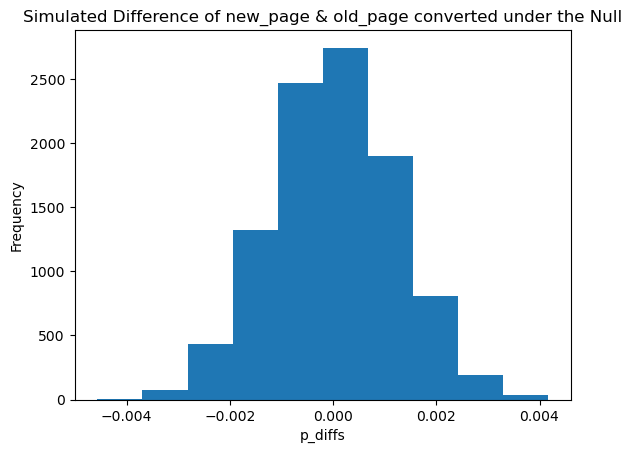

In [28]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null')

j. then to show that the proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [29]:
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')

# display observed difference
obs_diff = df_treatment.converted.mean() - df_control.converted.mean()
obs_diff

-0.0015782389853555567

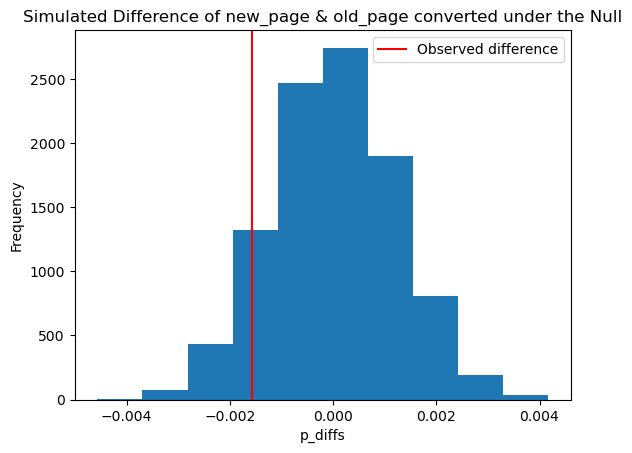

In [30]:
# plot line for observed statistic
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');
plt.legend()
plt.show()

In [31]:
#calculate the proportion of p_diffs greater than the observe difference
(p_diffs > obs_diff).mean()

0.9098

90.98% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv.

k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

90.98% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called **p-value**. This value means that **we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.** 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [53]:
import statsmodels.api as sm

n_new = len(df2.query('landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))

In [54]:
convert_new, convert_old

(17264, 17489)

In [55]:
n_new, n_old

(145310, 145274)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [56]:
#需要计算出z_score 和 p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is  larger than the old_page. 

<a id='regression'></a>
### Part III - A regression approach（optional）

`1.` Acheived in the previous A/B test can also be acheived by performing regression.<br><br>


Since each row represents either a conversion or no conversion, we should perform logistic regression in this case. 

b. Our goal is to use **statsmodels** to fit the regression model specified in part a to determine if there is a significant difference in conversion based on the page received by each customer. However, before fitting the model, we need to create two additional columns. 

First, we need to add an **intercept column**. This column will contain a constant value of 1 for each observation in the dataset. It is necessary for the **logistic regression model**.

Second, we need to create a **dummy variable column** to represent which page each user received. We will create an **"ab_page"** column, which will be assigned a value of 1 if an individual received the treatment (new page) and 0 if they were in the control group (old page).

By adding these columns, our dataset will be ready for the logistic regression analysis, allowing us to evaluate the significance of the page in predicting conversions.

In [36]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [37]:
#把treatment列名变为ab_page
df3 = df2.rename(columns={'treatment': 'ab_page'})
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0



c. Use **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [38]:
#statsmodels.api.Logit
from scipy import stats
4
df3['intercept'] = 1
df3 = df3.dropna()

In [39]:
#df3['ab_page'] = df3['ab_page'].astype(int)

In [40]:
lm = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Jun 2023   Pseudo R-squ.:               8.077e-06
Time:                        12:32:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Based on the provided regression analysis results, the following conclusions can be drawn:

- We used a Logit regression model to predict conversion rate.
- The number of observations in the sample is 290,584, which represents the total number of observations analyzed.
- The model was fitted using the Maximum Likelihood Estimation (MLE) method.
- The model has 1 degree of freedom for the model and 290,582 degrees of freedom for residuals.
- The pseudo R-squared value is 8.077e-06, which is close to zero, indicating that the model has a weak explanatory power for the target variable.
- The model has a good fit as indicated by the converged value of True, indicating that the model has converged.
- The Log-Likelihood value is -1.0639e+05, which can be used to compare the goodness of fit among different models.
- In terms of statistical significance testing, the intercept has a very small p-value (close to zero), indicating that the intercept term is significant in the model.
- The coefficient for ab_page is -0.0150 with a p-value of 0.190, which is relatively large (greater than 0.05), suggesting that the ab_page variable is not statistically significant and does not have a significant relationship with the conversion rate.

It is important to note that while the model fits the overall dataset well, the coefficient and p-value for ab_page indicate that there is no significant relationship between ab_page and the conversion rate. Therefore, further exploration of other variables or reconsideration of the model's construction may be necessary.

e. What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**?<br><br> What are the null and alternative hypotheses associated with the regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.19. It is higher than 0.05. Thus, **the coefficient is not significant.** 

Alternative hypothesis from part II: the conversion rate of the old_page is less than the conversion rate of the new_page. This assumes a one-tailed test. In Part III, the alternative hypothesis can be formulated as follows: 
(1) The landing_page type influences (positively or negatively) the conversion rate or (2) the conversion rate of the old_page is different to the conversion rate of the new_page. This assumes a two-tailed test.

in both cases, the results do not support the alternative hypothesis sufficiently. 

The p-value is very different. In part II the p-value is 0.91. This might be because the tests of the regression model (not the A/B test) assumes an intercept and because of differences in one or two-tailed testing. 

f. Now, you are considering other things that might influence whether or not an individual converts.

It is a good idea to consider other factors in order to **identify other potencial influences on the conversion rate.** 

A **disadvantage is that the model gets more complex**. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [58]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [59]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [60]:
#mean of conversion rate
df_new.ab_page.mean()

0.5000619442226688

In [61]:
df_new['country'] = df_new['country'].astype(str)


In [62]:
df_new.groupby(['country'], as_index=False).mean()

/var/folders/1r/j7hbz3757qbc87pbw8ghcq6h0000gp/T/ipykernel_30407/3307943571.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['country'], as_index=False).mean()


,country,converted,ab_page,intercept
0,CA,0.115318,0.503552,1.0
1,UK,0.120594,0.498247,1.0
2,US,0.119547,0.500459,1.0


In [63]:
#mean conversion rate by landing_page 
df_new.groupby(['ab_page'], as_index=False).mean()

/var/folders/1r/j7hbz3757qbc87pbw8ghcq6h0000gp/T/ipykernel_30407/1451119756.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['ab_page'], as_index=False).mean()


,ab_page,converted,intercept
0,0,0.120386,1.0
1,1,0.118808,1.0


In [64]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [66]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','US']])
results = lm.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 11 Jun 2023   Pseudo R-squ.:               2.323e-05
Time:                        16:15:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

The country does not appear to have influence on the convertion rate. P-values for the two dummy country variables are above 0.05. Note the CA variable get closes to 0.05.  

h. We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  


In [49]:
#mean conversion rate by country and landing_page - 
#checking for possible interactions (whether the influence of landing_page
#is different for the countries)
df_new.groupby(['country','ab_page'], as_index=False).mean()

/var/folders/1r/j7hbz3757qbc87pbw8ghcq6h0000gp/T/ipykernel_30407/2941443894.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['country','ab_page'], as_index=False).mean()


,country,ab_page,converted,intercept,CA,UK,US
0,CA,0,0.118783,1.0,1.0,0.0,0.0
1,CA,1,0.111902,1.0,1.0,0.0,0.0
2,UK,0,0.120022,1.0,0.0,1.0,0.0
3,UK,1,0.121171,1.0,0.0,1.0,0.0
4,US,0,0.120630,1.0,0.0,0.0,1.0
5,US,1,0.118466,1.0,0.0,0.0,1.0


By looking at an interaction, I will explore whether the influence of the landing_page might work in the US but not in the other countries, or Canada but not in other countries. Or the other way around. 


In [50]:
df_new.head()
df_new['interaction_us_ab_page'] = df_new.US *df_new.ab_page
df_new['interaction_ca_ab_page'] = df_new.CA *df_new.ab_page

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,interaction_us_ab_page,interaction_ca_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [51]:
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','interaction_us_ab_page','CA','interaction_ca_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 Jun 2023   Pseudo R-squ.:               3.482e-05
Time:                        12:32:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page                    0.0108      0.023      0.475      0.635      -0.034       0.056
US                         0.0057      0.019      0.306      0.760      -0.031       0.043
interaction_us_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA                        -0.0118      0.040     -0.296      0.767      -0.090       0.066
interaction_ca_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==========================================================================================
"""

### Summary and conclusion on regression

The p_value for both interaction terms is higher than 0.05.

Thus, the influence of landing_page in the US is not different to the influence of landing_page in the other countries. 

And the influence of landing_page in Canada is not different to the influence of landing_page in the other countries. 

<a id='conclusions'></a>
## Conclusions

In conclusion, there is not enough evidence that the new_page increases the conversion rate as compared to the old_page. This is based on the probability figures, A/B testand regression. There is no strong evidence that the countries (US, CA and UK) influence the conversion rate. 

Since the sample size is large continuing the testing of the new_page is likely not necessary. It is best to focus on the development of another new landing page. 

